### Análisis de Carga Útil:

- Considerar técnicas de procesamiento de lenguaje natural (NLP) para analizar el contenido de *Payload Data*, 
buscando firmas de malware conocidas o patrones anómalos.

1. **Carga de datos**

In [61]:
import pandas as pd
import numpy as np
import re

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping

data = pd.read_csv('cybersecurity_attacks.csv')
payload_data = data['Payload Data']

2. **Limpieza de datos**

In [64]:

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)  # Remover todos los caracteres especiales
    text = re.sub(r'\s+', ' ', text)  # Remover espacios extras

    return text

cleaned_payload_data = payload_data.apply(clean_text)


3. **Tokenización y Extracción de Características**

In [65]:


# Convertir etiquetas categóricas a numéricas
label_encoder = LabelEncoder()
integer_encoder = label_encoder.fit_transform(data['Attack Type'])

# Convertir enteros a one-hot encoding
labels = to_categorical(integer_encoder)


# Inicializar el Tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(cleaned_payload_data)

# Convertir texto a secuencias de enteros
sequences = tokenizer.texts_to_sequences(cleaned_payload_data)

# Rellenar las secuencias para tener la misma longitud
padded_sequences = pad_sequences(sequences, maxlen=120, truncating='post', padding='post')


In [66]:
# Dividir los datos en entrenamiento y prueba
# Asumiendo que `padded_sequences` es tu matriz de entrada y `labels` son tus etiquetas
X = padded_sequences
y = np.array(labels)  # Asegúrate de que las etiquetas sean un numpy array

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

4. **Construcción del modelo**

In [90]:

model = Sequential([
    Embedding(input_dim=10000, output_dim=16),
    Conv1D(64, 5, activation='relu'), # Añadimos una capa convolucional 1D
    MaxPooling1D(pool_size=4), # Añadimos una capa de pooling
    LSTM(64), # Opcional, puedes combinar convolucionales y LSTM
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(labels[0]), activation='softmax') # 'len(labels[0])' es el número de clases únicas
])


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [91]:
# Inicializar el callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 26s 29ms/step - accuracy: 0.3369 - loss: 1.0989 - val_accuracy: 0.3306 - val_loss: 1.0988
Epoch 2/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - accuracy: 0.3303 - loss: 1.0988 - val_accuracy: 0.3306 - val_loss: 1.0985
Epoch 3/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 23s 29ms/step - accuracy: 0.3390 - loss: 1.0986 - val_accuracy: 0.3436 - val_loss: 1.0986
Epoch 4/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 23s 28ms/step - accuracy: 0.3367 - loss: 1.0987 - val_accuracy: 0.3436 - val_loss: 1.0985
Epoch 5/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 23s 29ms/step - accuracy: 0.3376 - loss: 1.0986 - val_accuracy: 0.3436 - val_loss: 1.0986
Epoch 6/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 24s 29ms/step - accuracy: 0.3298 - loss: 1.0987 - val_accuracy: 0.3436 - val_loss: 1.0984
Epoch 7/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 23s 28ms/step - accuracy: 0.3306 - loss: 1.0987 - val_accuracy: 0.3436 - val_loss: 1.0985
Epoch 8/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 23s 28ms/step - accuracy: 0.3357 - loss: 1.0986 - 

In [92]:
model.save('payload_data_model.keras')

In [93]:
# Hacer predicciones
predictions = model.predict(X_test)

# Convertir las probabilidades a etiquetas definitivas
predicted_classes = np.argmax(predictions, axis=1)

# Convertir las etiquetas a clases reales
true_classes = np.argmax(y_test, axis=1)


250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [95]:
from sklearn.metrics import classification_report, confusion_matrix

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Calcular un informe de clasificación
class_report = classification_report(true_classes, predicted_classes)

# Mostrar las métricas
print(conf_matrix)
print(class_report)


[[   0    0 2636]
 [   0    0 2721]
 [   0    0 2643]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2636
           1       0.00      0.00      0.00      2721
           2       0.33      1.00      0.50      2643

    accuracy                           0.33      8000
   macro avg       0.11      0.33      0.17      8000
weighted avg       0.11      0.33      0.16      8000



/Users/hector/talent24/tensor/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hector/talent24/tensor/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hector/talent24/tensor/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

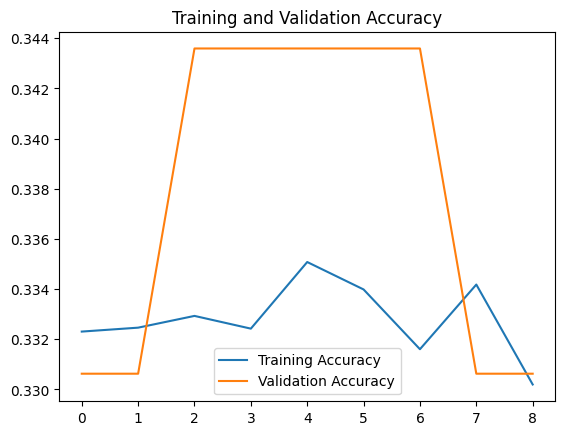

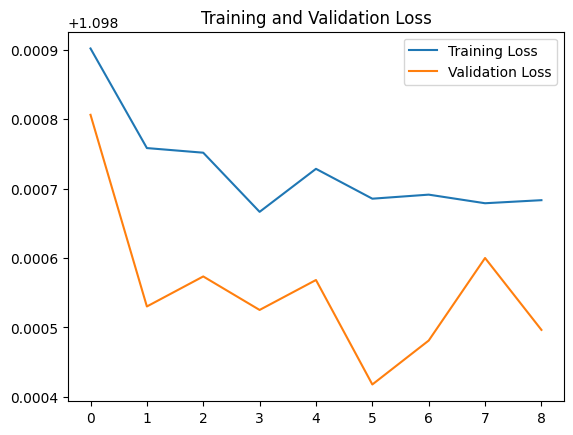

In [96]:
import matplotlib.pyplot as plt

# Graficar la precisión de entrenamiento y validación
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Graficar la pérdida de entrenamiento y validación
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
